<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import copy

# For the data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# The EMNIST Dataset

In [2]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Download the dataset
cdata = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

In [4]:
# Inspect the data
print(cdata.classes)
print(str(len(cdata.classes)) + " classes")
print()
print(f"Data size is {cdata.data.shape}")

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size is torch.Size([124800, 28, 28])


In [5]:
# Transform the data into 4D tensors for convolution layers (and from int8 into float)
images = cdata.data.view([124800,1,28,28]).float()
print(f"Images shape is {images.shape}")
# Data are grey-scale

Images shape is torch.Size([124800, 1, 28, 28])


In [6]:
# About the N/A
print(torch.sum(cdata.targets==0))
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [7]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
# Eliminate N/A and subtract one from the categories
# Remove the first class category
letterCategories = cdata.classes[1:]

# Relabel the labels from 0-25
labels = copy.deepcopy(cdata.targets) - 1
print(labels.shape)

print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

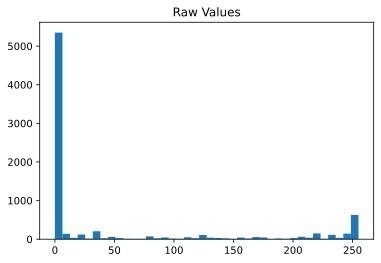

In [9]:
# Image normalization
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title("Raw Values")
plt.show()

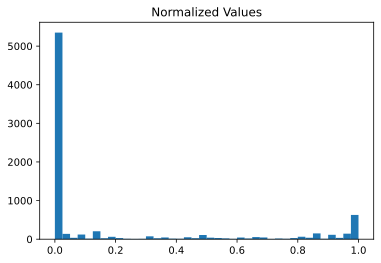

In [10]:
# Normalize
images /= torch.max(images)
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title("Normalized Values")
plt.show()

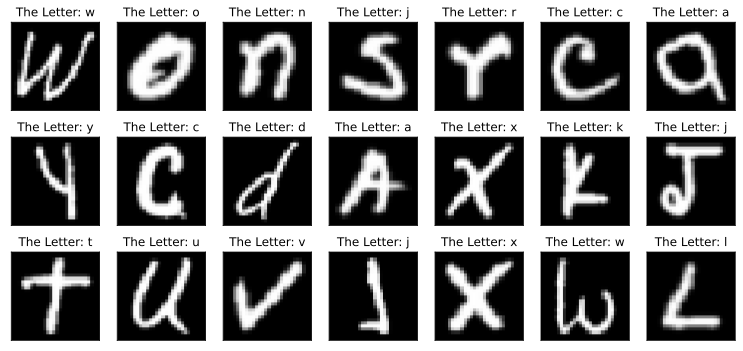

In [11]:
# Visualize some of them
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

    whichpic = np.random.randint(images.shape[0])

    # Extract image and its target letter
    I = np.squeeze(images[whichpic,:,:,:])
    letter = letterCategories[labels[whichpic]]

    ax.imshow(I.T, cmap="gray")
    ax.set_title(f"The Letter: {letter}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create Train and Test Groups

In [12]:
# Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])
torch.Size([12480, 1, 28, 28])
torch.Size([12480])


## Create the DL Model

In [14]:
def makeTheNet(printtoggle=False):

    class emnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # Define the convolution layers
            self.conv1 = nn.Conv2d(1,6,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(6) # Input the number of channels in this layer
            # size: np.floor((28+2*1-3)/1) +1 = 28/2 = 14

            self.conv2 = nn.Conv2d(6,6,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)
            # size: np.floor((14+2*1-3)/1) +1 = 14/2 = 7

            # Fully-connected layer
            self.fc1 = nn.Linear(7*7*6,50)

            # Output layer
            self.fc2 = nn.Linear(50,26)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # Forward Pass
        def forward(self,x):
            
            # Printing the information for layers
            if self.print: print(f"Input: {list(x.shape)}")

            # Convolution -> maxpool -> leakyrelu
            # Maxpool window size is 2
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f"First CPR Block: {list(x.shape)}")

            # Again Convolution -> maxpool -> batchnorm -> leaky_relu
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f"Second CPR Block: {list(x.shape)}")

            # Reshape for linear layer
            # total number of elements/total # of data samples
            nUnits = x.shape.numel()/x.shape[0]
            # -1 is the batchsize (number of images)
            x = x.view(-1, int(nUnits))
            if self.print: print(f"Vectorized: {x.shape}")

            # Linear Layers
            x = F.leaky_relu(self.fc1(x))
            if self.print: print(f"Layer fc1: {list(x.shape)}")
            x = self.fc2(x)
            if self.print: print(f"Layer Out: {list(x.shape)}")

            return x

    # Create the model instance
    net = emnistNet(printtoggle)

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [15]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print(yHat.shape)
print(y.shape)

Input: [32, 1, 28, 28]
First CPR Block: [32, 6, 14, 14]
Second CPR Block: [32, 6, 7, 7]
Vectorized: torch.Size([32, 294])
Layer fc1: [32, 50]
Layer Out: [32, 26]
torch.Size([32, 26])
torch.Size([32])


In [16]:
loss = lossfun(yHat,y)
print(loss)

tensor(3.3353, grad_fn=<NllLossBackward0>)


In [17]:
def function2trainThemodel():

    # Define the number of epochs
    numepochs = 20

    # Create a new model instance
    net, lossfun, optimizer = makeTheNet()

    # Send the model to the GPU
    net.to(device)

    # initialize the losses
    losses = np.zeros((numepochs,2))
    trainErr = []
    testErr = []

    # Loop over the epochs
    for epochi in range(numepochs):

        net.train()

        batchErr = []
        batchLoss = []
        for X,y in train_loader:

            # Data to the GPU
            X = X.to(device)
            y = y.to(device)

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())

            # Compute the accuracy of the batch
            batchErr.append(100*torch.mean((torch.argmax(yHat,axis=1) !=y).float()).item())
        # End of he batch loop

        # Get the values for training accuracy of a single epoch
        trainErr.append(np.mean(batchErr))

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))

        # Push data to the GPU
        X = X.to(device)
        y = y.to(device)

        # Deactivate the autograd
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testErr.append(100*torch.mean((torch.argmax(yHat,axis=1) !=y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    # End the Epochs
    return trainErr, testErr, losses, net

In [18]:
# Train the whole model using the same function as above
trainErr, testErr, losses, net = function2trainThemodel()

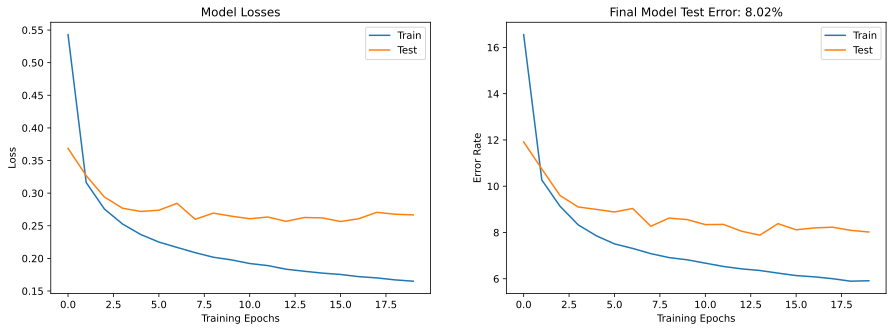

In [19]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainErr, label="Train")
ax[1].plot(testErr, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Error Rate")
ax[1].set_title("Final Model Test Error: {:.2f}%".format(testErr[-1]))
ax[1].legend()

plt.show()

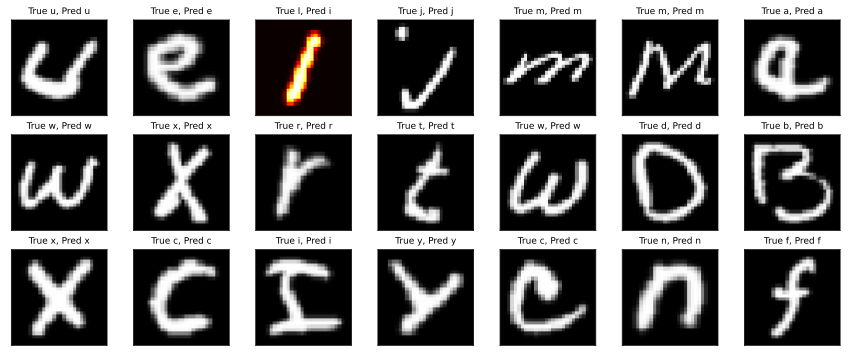

In [20]:
# visualize some images
X,y = next(iter(test_loader)) # extract X,y from test dataloader
X = X.to(device)
y = y.to(device)

yHat = net(X)

# Get some random image examples
randex = np.random.choice(len(y), size=21,replace=False)

fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

    whichpic = np.random.randint(images.shape[0])

    # Extract image and its target letter
    I = np.squeeze(X[randex[i],0,:,:]).cpu()
    trueLetter = letterCategories[y[randex[i]]]
    predLetter = letterCategories[torch.argmax(yHat[randex[i], :])]

    # COlor-code the accuracy using ternary operator
    col = "gray" if trueLetter==predLetter else "hot"

    ax.imshow(I.T, cmap=col)
    ax.set_title(f"True %s, Pred %s" %(trueLetter, predLetter), fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Accuracy by Letter

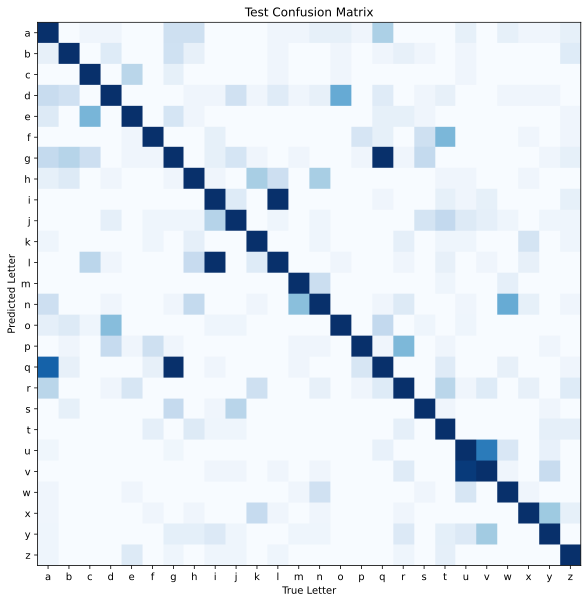

In [21]:
import sklearn.metrics as skm

# Compute the confusion matrix
C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(),axis=1), normalize="true")

# Visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C, "Blues", vmax=0.05)

plt.xticks(range(26), labels=letterCategories)
plt.yticks(range(26), labels=letterCategories)
plt.title("Test Confusion Matrix")
plt.xlabel("True Letter")
plt.ylabel("Predicted Letter")

plt.show()

# Modify Model Architecture

Create an architecture that has about 5% error rate.

In [22]:
def makeTheNet(printtoggle=False):

    class emnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # Define the convolution layers
            self.conv1 = nn.Conv2d(1,64,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(64) # Input the number of channels in this layer
            # size: np.floor((28+2*1-3)/1) +1 = 28/2 = 14

            # Second convolution layer
            self.conv2 = nn.Conv2d(64,128,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(128)
            # size: np.floor((14+2*0-3)/1) +1 = 12/2 = 6

            # Third Convolution Layer
            self.conv3 = nn.Conv2d(128,256,3)
            self.bnorm3 = nn.BatchNorm2d(256)
            # output size: (6+2*0-3)/1 + 1 = 4/2 = 2

            # Fully-connected layer
            self.fc1 = nn.Linear(2*2*256,256)

            # Fully-connected layer 2
            self.fc2 = nn.Linear(256,64)

            # Output Layer
            self.fc3 = nn.Linear(64,26)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # Forward Pass
        def forward(self,x):
            
            # Printing the information for layers
            if self.print: print(f"Input: {list(x.shape)}")

            # Convolution -> maxpool -> leakyrelu
            # Maxpool window size is 2
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            x = F.dropout(x, p=0.2, training=self.training)
            if self.print: print(f"First CPR Block: {list(x.shape)}")

            # Again Convolution -> maxpool -> batchnorm -> leaky_relu
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            x = F.dropout(x, p=0.2, training=self.training)
            if self.print: print(f"Second CPR Block: {list(x.shape)}")

            x = F.max_pool2d(self.conv3(x),2)
            x = F.leaky_relu(self.bnorm3(x))
            x = F.dropout(x, p=0.2, training=self.training)
            if self.print: print(f"Third CPR Block: {list(x.shape)}")

            # Reshape for linear layer
            # total number of elements/total # of data samples
            nUnits = x.shape.numel()/x.shape[0]
            # -1 is the batchsize (number of images)
            x = x.view(-1, int(nUnits))
            if self.print: print(f"Vectorized: {x.shape}")

            # Linear Layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f"Layer fc1: {list(x.shape)}")
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.fc3(x)
            if self.print: print(f"Layer Out: {list(x.shape)}")

            return x

    # Create the model instance
    net = emnistNet(printtoggle)

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [23]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print(yHat.shape)
print(y.shape)

Input: [32, 1, 28, 28]
First CPR Block: [32, 64, 14, 14]
Second CPR Block: [32, 128, 7, 7]
Third CPR Block: [32, 256, 2, 2]
Vectorized: torch.Size([32, 1024])
Layer fc1: [32, 256]
Layer Out: [32, 26]
torch.Size([32, 26])
torch.Size([32])


In [24]:
loss = lossfun(yHat,y)
print(loss)

tensor(3.2586, grad_fn=<NllLossBackward0>)


In [25]:
# Train the whole model using the same function as above
trainErr, testErr, losses, net = function2trainThemodel()

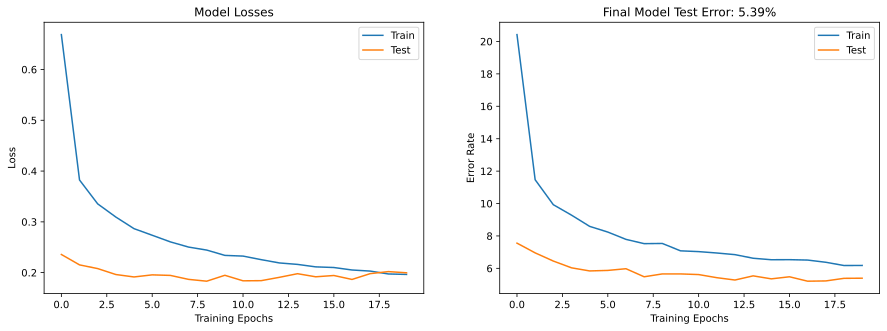

In [26]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainErr, label="Train")
ax[1].plot(testErr, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Error Rate")
ax[1].set_title("Final Model Test Error: {:.2f}%".format(testErr[-1]))
ax[1].legend()

plt.show()

In [27]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
X = X.to(device)
y = y.to(device)

yHat = net(X)

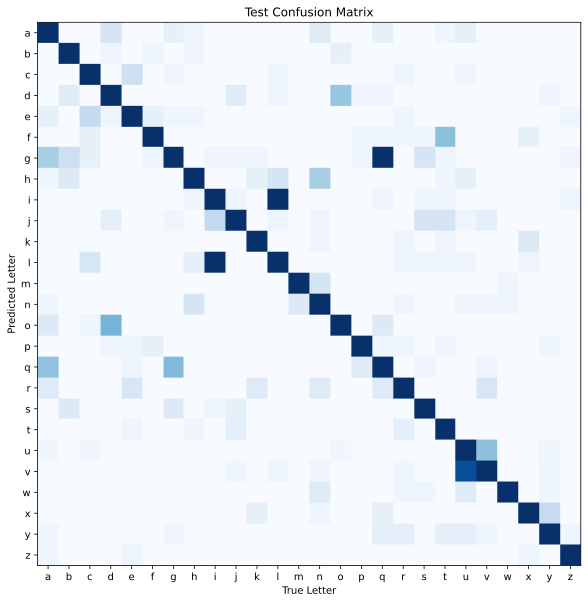

In [28]:
# Compute the confusion matrix
C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(),axis=1), normalize="true")

# Visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C, "Blues", vmax=0.05)

plt.xticks(range(26), labels=letterCategories)
plt.yticks(range(26), labels=letterCategories)
plt.title("Test Confusion Matrix")
plt.xlabel("True Letter")
plt.ylabel("Predicted Letter")

plt.show()

# Code Challenge: Varying Number of Channels

Set the number of channels (learned kernels, feature maps) of the two convolution layers soft-coded

Run experiment with [2,5,8] for each layer(9 models in total: train for 5 epochs)

Show results in 3x3 matrix of the final error rates from each test, and as a function of kernel filters

In [29]:
# Keep the original model architecture
def makeTheNet(numChans=(6,6)):

    class emnistNet(nn.Module):
        def __init__(self, numChans):
            super().__init__()

            # Define the convolution layers
            self.conv1 = nn.Conv2d(1,numChans[0],3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(numChans[0])

            self.conv2 = nn.Conv2d(numChans[0],numChans[1],3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(numChans[1])

            # Fully-connected layer
            self.fc1 = nn.Linear(7*7*numChans[1],50)

            # Output layer
            self.fc2 = nn.Linear(50,26)

        # Forward Pass
        def forward(self,x):

            # Convolution -> maxpool -> leakyrelu
            # Maxpool window size is 2
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))

            # Again Convolution -> maxpool -> batchnorm -> leaky_relu
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))

            # Reshape for linear layer
            # total number of elements/total # of data samples
            nUnits = x.shape.numel()/x.shape[0]
            # -1 is the batchsize (number of images)
            x = x.view(-1, int(nUnits))

            # Linear Layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)

            return x

    # Create the model instance
    net = emnistNet(numChans)

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [30]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = makeTheNet((6,12))

X,y = next(iter(train_loader))
yHat = net(X)

loss = lossfun(yHat,y)

print(yHat.shape)
print(y.shape)
print(loss)

torch.Size([32, 26])
torch.Size([32])
tensor(3.2643, grad_fn=<NllLossBackward0>)


In [31]:
def function2trainThemodel(numChans):

    # Define the number of epochs
    numepochs = 5

    # Create a new model instance
    net, lossfun, optimizer = makeTheNet(numChans)

    # Send the model to the GPU
    net.to(device)

    # initialize the losses
    losses = np.zeros((numepochs,2))
    trainErr = []
    testErr = []

    # Loop over the epochs
    for epochi in range(numepochs):

        net.train()

        batchErr = []
        batchLoss = []
        for X,y in train_loader:

            # Data to the GPU
            X = X.to(device)
            y = y.to(device)

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())

            # Compute the accuracy of the batch
            batchErr.append(100*torch.mean((torch.argmax(yHat,axis=1) !=y).float()).item())
        # End of he batch loop

        # Get the values for training accuracy of a single epoch
        trainErr.append(np.mean(batchErr))

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))

        # Push data to the GPU
        X = X.to(device)
        y = y.to(device)

        # Deactivate the autograd
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testErr.append(100*torch.mean((torch.argmax(yHat,axis=1) !=y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    # End the Epochs
    return trainErr, testErr, losses, net

In [32]:
# Train the whole model using the same function as above
trainErr, testErr, losses, net = function2trainThemodel((3,7))

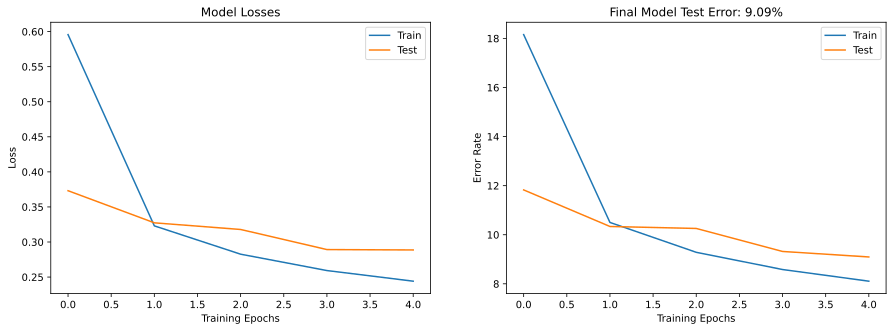

In [33]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainErr, label="Train")
ax[1].plot(testErr, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Error Rate")
ax[1].set_title("Final Model Test Error: {:.2f}%".format(testErr[-1]))
ax[1].legend()

plt.show()

In [34]:
# Experiment Time
convChans = [2,5,8]

# Initialize the results matrix
results = np.zeros((len(convChans), len(convChans), 2))
convParams = np.zeros((len(convChans), len(convChans)))

for i, Nchani in enumerate(convChans):
    for j, Nchanj in enumerate(convChans):

        # Run the model
        trainErr, testErr, losses, net = function2trainThemodel((Nchani, Nchanj))

        # Store the results
        results[i,j,:] = trainErr[-1], testErr[-1]
        convParams[i,j] = Nchani + Nchanj # Total number of convolution layer channels

        print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


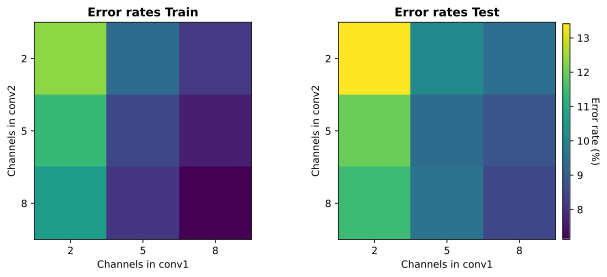

In [35]:
# Show the results matrix
fig,ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    h = ax[i].imshow(results[:,:,i],vmin=np.min(results),vmax=np.max(results))
    ax[i].set_xlabel('Channels in conv1')
    ax[i].set_ylabel('Channels in conv2')
    ax[i].set_xticks(range(j+1)) # j defined in previous cell
    ax[i].set_yticks(range(j+1))
    ax[i].set_xticklabels(convChans)
    ax[i].set_yticklabels(convChans)
    title = 'Train' if i==0 else 'Test'
    ax[i].set_title('Error rates %s'%title,fontweight='bold')


# add a colorbar right of the plot (use common colorscaling for both plots)
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1+.01,axpos.y0,.01,.75])
hh = fig.colorbar(h,cax=cax)
hh.set_label('Error rate (%)',rotation=270,labelpad=10)

plt.show()

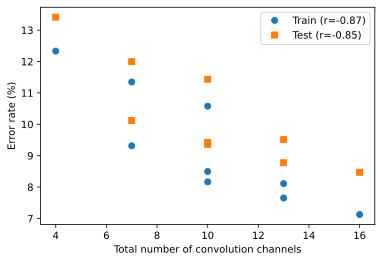

In [36]:
# error rate as a function of the total number of conv channels
corrTrain = np.corrcoef(convParams.flatten(),results[:,:,0].flatten())
corrTest  = np.corrcoef(convParams.flatten(),results[:,:,1].flatten())

# plots
plt.plot(convParams.flatten(),results[:,:,0].flatten(),'o',
         label=f'Train (r={corrTrain[0,1]:.2f})')
plt.plot(convParams.flatten(),results[:,:,1].flatten(),'s',
         label=f'Test (r={corrTest[0,1]:.2f})')

# other stuff etc
plt.legend()
plt.xlabel('Total number of convolution channels')
plt.ylabel('Error rate (%)')
plt.show()